Loaded Random Forest data successfully.
Random Forest has 168 features
Loaded XGBoost data successfully.
XGBoost has 168 features
Loaded Logistic Regression data successfully.
Logistic Regression has 168 features
Loaded CatBoost data successfully.
CatBoost model type: <class 'catboost.core.CatBoostClassifier'>

=== Debug: CatBoost file structure ===
Type: <class 'dict'>
Keys: ['model', 'label_encoder', 'features', 'categorical_features']
  model: <class 'catboost.core.CatBoostClassifier'>
    Has feature_importances_: 51 features
    Has feature_names_: ['Area (m2)', 'log_Area (m2)', 'inv_nearest_dist', 'inv_nearest_category', 'natural_dist']...
  label_encoder: <class 'sklearn.preprocessing._label.LabelEncoder'>
  features: <class 'list'>
  categorical_features: <class 'list'>


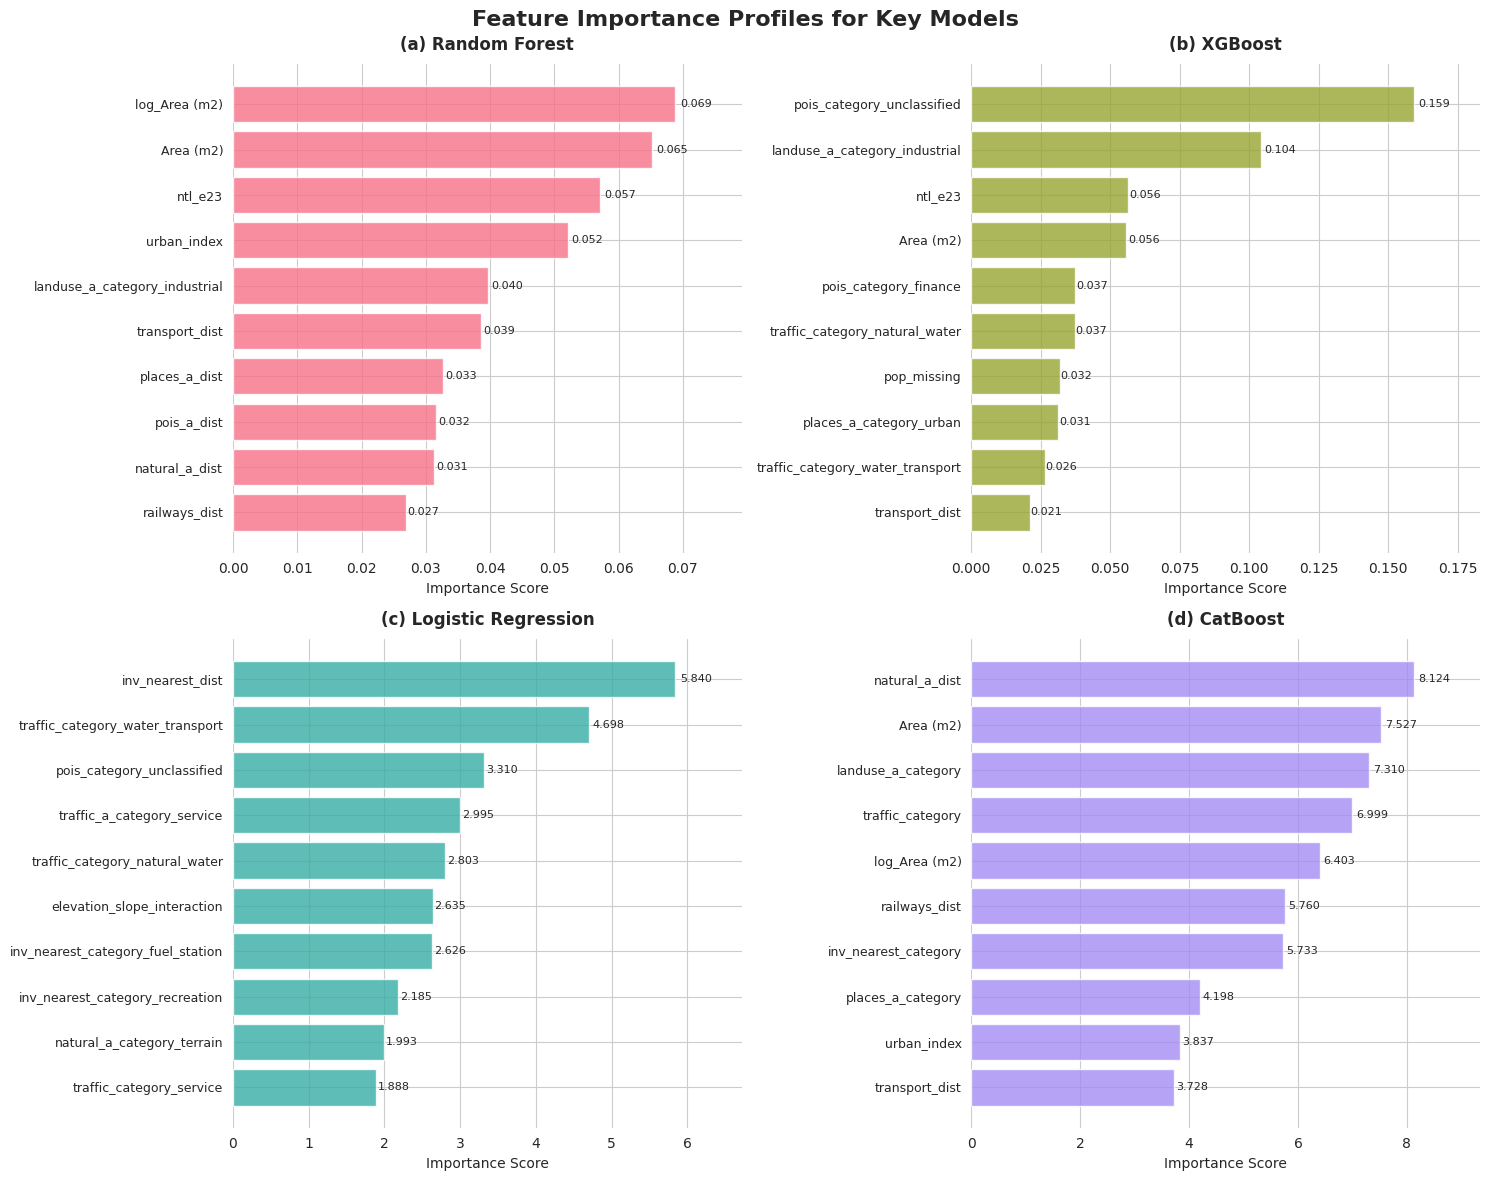


Feature Importance Data Extracted:

Random Forest:
  log_Area (m2): 0.0688
  Area (m2): 0.0652
  ntl_e23: 0.0572
  urban_index: 0.0521
  landuse_a_category_industrial: 0.0397
  transport_dist: 0.0385
  places_a_dist: 0.0327
  pois_a_dist: 0.0316
  natural_a_dist: 0.0312
  railways_dist: 0.0269

XGBoost:
  pois_category_unclassified: 0.1591
  landuse_a_category_industrial: 0.1042
  ntl_e23: 0.0562
  Area (m2): 0.0557
  pois_category_finance: 0.0374
  traffic_category_natural_water: 0.0372
  pop_missing: 0.0318
  places_a_category_urban: 0.0312
  traffic_category_water_transport: 0.0264
  transport_dist: 0.0210

Logistic Regression:
  inv_nearest_dist: 5.8402
  traffic_category_water_transport: 4.6984
  pois_category_unclassified: 3.3096
  traffic_a_category_service: 2.9948
  traffic_category_natural_water: 2.8028
  elevation_slope_interaction: 2.6355
  inv_nearest_category_fuel_station: 2.6255
  inv_nearest_category_recreation: 2.1846
  natural_a_category_terrain: 1.9932
  traffic_cate

In [9]:
# Import necessary libraries
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 1. Define the paths to your model files
model_paths = {
    "Random Forest": "D:/VS Code/Building classification/gis/Data_files/BD_Dataset_OSM/UTM 46N/final layers/rf_files/final_rf_model_psedo.joblib",
    "XGBoost": "D:/VS Code/Building classification/gis/Data_files/BD_Dataset_OSM/UTM 46N/final layers/xgb_files/final_xgb_model_psedo.joblib",
    "Logistic Regression": "D:/VS Code/Building classification/gis/Data_files/BD_Dataset_OSM/UTM 46N/final layers/lr_files/final_lr_model_psedo.joblib",
    "CatBoost": "D:/VS Code/Building classification/gis/Data_files/BD_Dataset_OSM/UTM 46N/final layers/cb_files/final_cb_model_psedo.joblib" 
}

# 2. Function to extract feature names from the preprocessor
def extract_feature_names(preprocessor):
    """Extract feature names from a ColumnTransformer preprocessor"""
    try:
        # Numeric feature names
        num_features = preprocessor.transformers_[0][2]  # list of numeric feature names
        
        # Categorical feature names after one-hot encoding
        cat_pipeline = preprocessor.transformers_[1][1]
        cat_features_raw = preprocessor.transformers_[1][2]
        
        # Extract one-hot encoder inside categorical pipeline
        onehot = cat_pipeline.named_steps['onehot']
        
        # Get categorical feature names after encoding
        cat_feature_names = onehot.get_feature_names_out(cat_features_raw)
        
        # Combine numeric and categorical feature names
        feature_names = np.array(list(num_features) + list(cat_feature_names))
        
        return feature_names
        
    except Exception as e:
        print(f"Error extracting feature names: {e}")
        # Fallback: create generic feature names
        if hasattr(preprocessor, 'n_features_in_'):
            return [f'Feature_{i}' for i in range(preprocessor.n_features_in_)]
        else:
            return None

# 3. Load the models and extract feature importances
importance_data = {}

for name, path in model_paths.items():
    try:
        # Load the saved data
        saved = joblib.load(path)
        print(f"Loaded {name} data successfully.")
        
        # Handle CatBoost separately (it might be a direct CatBoost model)
        if name == "CatBoost":
            # Check if it's a direct CatBoost model or has the same pipeline structure
            if 'model' in saved and hasattr(saved['model'], 'named_steps'):
                # CatBoost in pipeline structure (same as others)
                model = saved['model']
                preprocessor = model.named_steps['preprocessor']
                classifier = model.named_steps['classifier']
                
                # Extract feature names
                feature_names = extract_feature_names(preprocessor)
                
                if hasattr(classifier, 'feature_importances_'):
                    importances = classifier.feature_importances_
                    
                    # Create a dictionary of top 10 features
                    idx = np.argsort(importances)[-10:][::-1]
                    top_features = [feature_names[i] for i in idx]
                    top_importance = importances[idx]
                    importance_data[name] = dict(zip(top_features, top_importance))
            
            else:
                # Direct CatBoost model (different structure)
                # Try to extract CatBoost model directly
                catboost_model = None
                if 'model' in saved:
                    catboost_model = saved['model']
                elif 'classifier' in saved:
                    catboost_model = saved['classifier']
                else:
                    # Assume the saved object is the CatBoost model itself
                    catboost_model = saved
                
                print(f"CatBoost model type: {type(catboost_model)}")
                
                # Get feature importances from CatBoost
                if hasattr(catboost_model, 'feature_importances_'):
                    importances = catboost_model.feature_importances_
                    
                    # Get feature names from CatBoost
                    if hasattr(catboost_model, 'feature_names_'):
                        feature_names = catboost_model.feature_names_
                    else:
                        # Create generic feature names
                        feature_names = [f'Feature_{i}' for i in range(len(importances))]
                    
                    # Create a dictionary of top 10 features
                    idx = np.argsort(importances)[-10:][::-1]
                    top_features = [feature_names[i] for i in idx]
                    top_importance = importances[idx]
                    importance_data[name] = dict(zip(top_features, top_importance))
        
        else:
            # Handle other models (Random Forest, XGBoost, Logistic Regression)
            model = saved['model']
            preprocessor = model.named_steps['preprocessor']
            classifier = model.named_steps['classifier']
            
            # Extract feature names
            feature_names = extract_feature_names(preprocessor)
            
            if feature_names is None:
                print(f"Could not extract feature names for {name}, using generic names")
                if hasattr(classifier, 'feature_importances_'):
                    n_features = len(classifier.feature_importances_)
                elif hasattr(classifier, 'coef_'):
                    n_features = len(classifier.coef_[0])
                else:
                    n_features = 100
                feature_names = [f'Feature_{i}' for i in range(n_features)]
            
            print(f"{name} has {len(feature_names)} features")
            
            # Extract feature importances based on classifier type
            if hasattr(classifier, 'feature_importances_'):
                importances = classifier.feature_importances_
                
                # Create a dictionary of top 10 features
                idx = np.argsort(importances)[-10:][::-1]
                top_features = [feature_names[i] for i in idx]
                top_importance = importances[idx]
                importance_data[name] = dict(zip(top_features, top_importance))
                
            elif hasattr(classifier, 'coef_'):
                coefficients = np.abs(classifier.coef_[0])
                
                # Create a dictionary of top 10 features
                idx = np.argsort(coefficients)[-10:][::-1]
                top_features = [feature_names[i] for i in idx]
                top_importance = coefficients[idx]
                importance_data[name] = dict(zip(top_features, top_importance))
                
            else:
                print(f"Classifier {name} doesn't have feature_importances_ or coef_ attributes")
            
    except Exception as e:
        print(f"Error processing {name}: {e}")
        import traceback
        traceback.print_exc()

# 4. Debug: Check what's in the CatBoost file specifically
print("\n=== Debug: CatBoost file structure ===")
try:
    catboost_data = joblib.load(model_paths["CatBoost"])
    print(f"Type: {type(catboost_data)}")
    if isinstance(catboost_data, dict):
        print("Keys:", list(catboost_data.keys()))
        for key, value in catboost_data.items():
            print(f"  {key}: {type(value)}")
            if hasattr(value, 'feature_importances_'):
                print(f"    Has feature_importances_: {len(value.feature_importances_)} features")
            if hasattr(value, 'feature_names_'):
                print(f"    Has feature_names_: {value.feature_names_[:5]}...")
except Exception as e:
    print(f"Error inspecting CatBoost file: {e}")

# 5. Check if we have any data to plot
if not importance_data:
    print("No feature importance data was extracted. Cannot create plots.")
else:
    # Create a function to prepare data for plotting
    def prepare_data(importance_dict, model_name):
        """Converts a dictionary to a sorted DataFrame for plotting."""
        df = pd.DataFrame(list(importance_dict.items()), columns=['Feature', 'Importance'])
        df['Model'] = model_name
        df = df.sort_values('Importance', ascending=True)
        return df

    # Prepare DataFrames for each model
    plot_dfs = {}
    for model_name, imp_dict in importance_data.items():
        plot_dfs[model_name] = prepare_data(imp_dict, model_name)

    # Set up the plot style
    sns.set_style("whitegrid")
    plt.rcParams['font.size'] = 10
    plt.rcParams['font.family'] = 'DejaVu Sans'
    
    # Determine how many models we have to plot
    n_models = len(importance_data)
    
    # Create appropriate subplot layout
    if n_models == 1:
        fig, axs = plt.subplots(1, 1, figsize=(10, 6))
        axs = [axs]
    elif n_models == 2:
        fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    elif n_models == 3:
        fig, axs = plt.subplots(1, 3, figsize=(20, 6))
    else:
        fig, axs = plt.subplots(2, 2, figsize=(15, 12))
        axs = axs.flatten()
    
    fig.suptitle('Feature Importance Profiles for Key Models', fontsize=16, fontweight='bold')
    
    # Create a horizontal bar plot for each model
    colors = sns.color_palette("husl", n_models)
    
    for i, (model_name, df) in enumerate(plot_dfs.items()):
        if i < len(axs):
            ax = axs[i]
            
            # Plot the data
            bars = ax.barh(df['Feature'], df['Importance'], color=colors[i], alpha=0.8)
            
            # Add value labels on the bars
            for bar in bars:
                width = bar.get_width()
                ax.text(width * 1.01, bar.get_y() + bar.get_height()/2, 
                       f'{width:.3f}', ha='left', va='center', fontsize=8)
            
            # Set the title for each subplot
            ax.set_title(f'({chr(97+i)}) {model_name}', fontsize=12, fontweight='bold', pad=10)
            
            # Label the x-axis
            ax.set_xlabel('Importance Score', fontsize=10)
            
            # Improve appearance
            ax.tick_params(axis='y', which='major', labelsize=9)
            sns.despine(left=True, bottom=True, ax=ax)
            
            # Set consistent x-limit
            max_importance = df['Importance'].max()
            ax.set_xlim(0, max_importance * 1.15)

    # Adjust layout and save the figure
    plt.tight_layout()
    plt.savefig('feature_importance_panels.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.savefig('feature_importance_panels.pdf', bbox_inches='tight', facecolor='white')
    plt.show()

    # Print the feature importance data for reference
    print("\nFeature Importance Data Extracted:")
    for model_name, imp_dict in importance_data.items():
        print(f"\n{model_name}:")
        for feature, importance in imp_dict.items():
            print(f"  {feature}: {importance:.4f}")

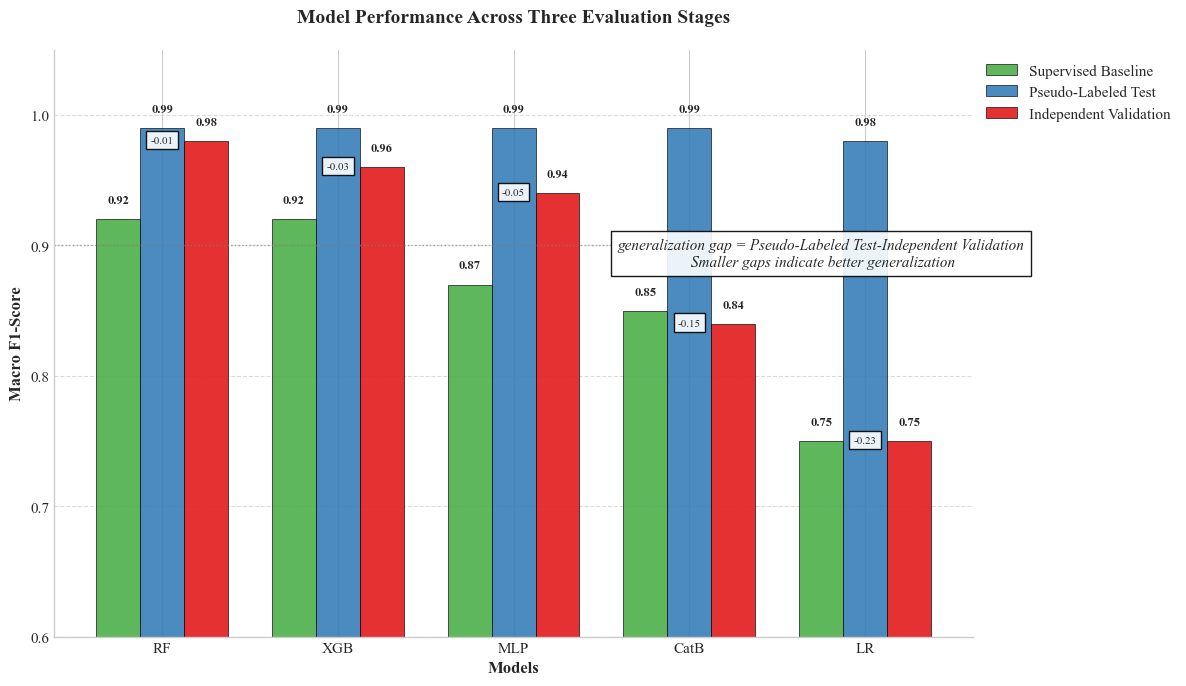

Performance Summary (Macro F1):
Model | Supervised | Pseudo-Test | Validation | Gen. Gap
-------------------------------------------------------
RF   |      0.92 |        0.99 |       0.98 |    0.01
XGB  |      0.92 |        0.99 |       0.96 |    0.03
MLP  |      0.87 |        0.99 |       0.94 |    0.05
CatB |      0.85 |        0.99 |       0.84 |    0.15
LR   |      0.75 |        0.98 |       0.75 |    0.23


In [26]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set style for publication-quality figure
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['legend.fontsize'] = 11

# Data extraction from your results (Macro F1 scores)
models = ['RF', 'XGB', 'MLP', 'CatB', 'LR']

# STAGE 1: Supervised Baseline (trained on original labeled data)
supervised_f1 = [0.92, 0.92, 0.87, 0.85, 0.75] # Macro Avg from your reports

# STAGE 2: Pseudo-Labeled Test Set Performance
pseudo_test_f1 = [0.99, 0.99, 0.99, 0.99, 0.98] # Macro Avg from your reports

# STAGE 3: Independent Validation (Ground Truth)
validation_f1 = [0.98, 0.96, 0.94, 0.84, 0.75] # Macro Avg from your reports

# Calculate generalization gaps
generalization_gaps = [pseudo - val for pseudo, val in zip(pseudo_test_f1, validation_f1)]

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 7))

# Set width of bars and positions
bar_width = 0.25
r1 = np.arange(len(models))                 # Position for supervised baseline
r2 = [x + bar_width for x in r1]            # Position for pseudo-test
r3 = [x + bar_width for x in r2]            # Position for validation

# Create bars for each stage
bars1 = ax.bar(r1, supervised_f1, width=bar_width, color='#4daf4a', alpha=0.9, label='Supervised Baseline', edgecolor='black', linewidth=0.5)
bars2 = ax.bar(r2, pseudo_test_f1, width=bar_width, color='#377eb8', alpha=0.9, label='Pseudo-Labeled Test', edgecolor='black', linewidth=0.5)
bars3 = ax.bar(r3, validation_f1, width=bar_width, color='#e41a1c', alpha=0.9, label='Independent Validation', edgecolor='black', linewidth=0.5)


# Add performance gap as text above the validation bars
for i, (pseudo, val) in enumerate(zip(pseudo_test_f1, validation_f1)):
    gap = pseudo - val
    ax.text(r2[i], val-0.003 , f'-{gap:.2f}', ha='center', va='bottom', fontsize=8, bbox={'facecolor': 'white', 'alpha': 0.9, 'pad': 3})

# Add value labels on top of bars
def add_value_labels(bars, offset=0.01):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + offset,
                f'{height:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

add_value_labels(bars1)
add_value_labels(bars2)
add_value_labels(bars3)

# Add labels and title
ax.set_xlabel('Models', fontweight='bold')
ax.set_ylabel('Macro F1-Score', fontweight='bold')
ax.set_title('Model Performance Across Three Evaluation Stages', fontweight='bold', pad=20)

# Set x-axis ticks and labels
ax.set_xticks([r + bar_width for r in range(len(models))])
ax.set_xticklabels(models)

# Set y-axis limit
ax.set_ylim(0.6, 1.05)

# Add legend
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Add grid for better readability
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add horizontal line at a reference point
ax.axhline(y=0.9, color='gray', linestyle=':', alpha=0.7, linewidth=1)

# Annotate the performance gap concept
ax.text(len(models)-1, max(validation_f1) * 0.9, 
        'generalization gap = Pseudo-Labeled Test-Independent Validation\n Smaller gaps indicate better generalization', 
        style='italic', bbox={'facecolor': 'white', 'alpha': 0.9, 'pad': 5}, ha='center', va='bottom')

# Adjust layout to prevent legend from being cut off
plt.tight_layout()

# Save figure in high resolution
plt.savefig('three_stage_model_performance.png', dpi=300, bbox_inches='tight')
plt.savefig('three_stage_model_performance.pdf', bbox_inches='tight')  # For publication

# Show plot
plt.show()

# Print performance summary for reference
print("Performance Summary (Macro F1):")
print("Model | Supervised | Pseudo-Test | Validation | Gen. Gap")
print("-" * 55)
for i, model in enumerate(models):
    gap = generalization_gaps[i]
    print(f"{model:4} | {supervised_f1[i]:9.2f} | {pseudo_test_f1[i]:11.2f} | {validation_f1[i]:10.2f} | {gap:7.2f}")